In [75]:
import random as rd
import numpy as np
import matplotlib.pyplot as plot



# MODELLO BASE

### Considero avviata la cascata dal momento in cui due partecipanti compiono la stessa scelta esco dal while e passo alla simulazione successiva. 
Innanzitutto vengono definiti quattro parametri: priorblue e priorred sono le probabilità a priori di avere l'urna con maggioranza blu o rossa rispettivamente, mentre blue e red rappresentano la corrispondenza tra segnale e colore della pallina.

Successivamente viene definita la probabilità q che dato lo stato "good" (cioè l'urna a maggioranza blu) si abbia un segnale "high" (cioè la pallina blu) e dato lo stato "bad" (cioè l'urna a maggioranza rossa) si abbia un segnale "low" (cioè la pallina blu).

Il codice è un'implementazione di un modello di "social learning", il cui obiettivo è studiare il modo in cui gli individui possono influenzarsi reciprocamente nella formazione delle proprie opinioni e decisioni.

Il modello utilizza un esempio concreto, ovvero una situazione in cui un gruppo di persone deve indovinare il contenuto di un'urna che contiene un certo numero di palline rosse e blu. Ogni partecipante effettua una estrazione dall'urna e decide se il contenuto è maggiormente rosso o blu. Gli altri partecipanti possono essere influenzati dalla scelta dei loro compagni e, in particolare, potrebbero cambiare idea se vedono che la maggioranza dei partecipanti ha scelto in modo diverso da loro.

Il modello si articola in diversi passaggi. Innanzitutto, viene definito lo "stato dell'universo", ovvero se la maggioranza delle palline nell'urna è rossa o blu. Vengono poi estratti casualmente un certo numero di partecipanti, ciascuno dei quali effettua un'estrazione dall'urna. In base al risultato dell'estrazione, ogni partecipante decide se il contenuto dell'urna è maggiormente rosso o blu.

Il primo passaggio consiste nel creare un vettore che raccoglie la giusta proporzione di palline rosse e blu in base allo stato dell'universo. Se la maggioranza delle palline è rossa, il vettore avrà due palline rosse e una blu, mentre se la maggioranza è blu, il vettore avrà due palline blu e una rossa.

La scelta di ogni partecipante viene influenzata da una probabilità di errore e dal parametro "q", che viene utilizzato per calcolare le probabilità "a priori" che l'urna contenga una maggioranza di palline rosse o blu, utilizzando il teorema di Bayes.

In [76]:
priorblue = 0.5
priorred = 0.5
blue = 0
red = 1
#q è la prob che dato lo stato good si abbia un high signal e dato lo stato bad si abbia un low signal (prob che la pallina sia rossa se l'urna è a maggioranza rossa e blu se è a maggioranza blu)
q = 2/3
num_sim = 100

    
#definisce in modo casuale lo stato dell'universo (maggioranza rossa, maggioranza blu)
def universe():
    state = rd.randint(0,1)
    return state

#definisce il numero di partecipanti all'esperimento
def partecipants():
    num = rd.randint(3,100)
    return num

#riempie un vettore con la corretta proporzione di palline a seconda dello stato dell'universo
def vector_world(state):
    alternative = [0,1]
    if state == 1:
        world = [1,1,0]
    else:
        world = [0,0,1]
    return world

#effettua l'estrazione della pallina dall'urna
def extraction(world):
    signal = rd.choice(world)
    return signal

#calcola la probabilità che data una serie di segnali, l'urna sia a maggioranza rossa o blu
def bayes(p, a , b , q):
    denom = (  p * (q**a) * ((1-q)**b) + (1-p) * ((1-q)**a) * (q**b) )
    if denom == 0:
        denom = np.nextafter(0, 1)
    post = ( p * (q**a) * ((1-q)**b) )/ denom
    return post

#effettua la scelta in base alle posterior
def make_decision(postblue, postred, signal):
    if postblue > postred:
        choice = 0
    elif postblue < postred:
        choice = 1 
    else:
        choice = signal
    return choice

#verifica se due giocatori compiono consecutivamente la stessa scelta dando quindi origine ad una cascata\n",
def controller(vector,i):
    if len(vector) == 1:   
        return None
    else:
        if vector[i] == vector[i - 1]:
            return False
        return True


#dinamica per un partecipante
def singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent):
    
    signal = extraction(world)
    if signal == state:
        correct_signal += 1
    if signal == 1:
        a += 1
    else:
        b += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred
   
    choice = make_decision(postblue, postred, signal)
    if signal == choice:
        count_coherent += 1
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

    else:
        if signal == 1: 
            a -= 1
            b += 1
        else:
            a += 1
            b -= 1        
        count_incoherent += 1     
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal


    
def rimuovi_None_e_segna_posizioni(vettore):
    posizioni_None = []
    vettore_senza_None = []
    for i, x in enumerate(vettore):
        if x == None:
            posizioni_None.append(i)
        else:
            vettore_senza_None.append(x)
    return vettore_senza_None, posizioni_None


def rimuovi_elementi(vettore, posizioni_da_rimuovere):
    vettore_senza_elementi = [x for i, x in enumerate(vettore) if i not in posizioni_da_rimuovere]
    return vettore_senza_elementi



count_coherent = 0
count_incoherent = 0


#vettore che raccoglie il numero di partecipanti per ogni ciclo su h
vector_participants = []
   
#vettore che raccoglie l'indice di ogni simulazione
vector_sim = []

#vettore che raccoglie il rate di cascate corrette facendo la media su numsim simulazioni
correct_cascade_rate = []

#vettore che raccoglie il numero di passi necessari a dare avvio ad una cascata facendo la media su numsim simulazioni
counter = []

#vettore che raccoglie il numero di cascate di informazioni totale facendo la media su numsim simulazioni
counter_cascade = []

#vettore che raccoglie le medie di rate di cascate corrette di numsim simulazioni
correct_cascade_rate_total = []

correct_cascade = 0

correct_guesses = []


for h in range(0,100):
    
    vector_sim.append(h)

    #estraggo casualmente il numero di partecipanti dell'esperimento
    numpart = partecipants()
    
    #vettore che raccoglie il numero di partecipanti ad ogni simulazione
    vector_participants.append(numpart)

    #conta il numero di simulazioni di tutte le numsim simulazioni
    number_steps = 0
    
    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di segnali corretti  (per ora non lo uso)
    correct_signal = 0

    #conta il rate di cascate corrette
    mean_correct_cascades = 0
    
    #conta il numero di cascate
    number_cascades = 0
        
    mean_steps = 0
    
    #conta il numero di passi che ci sono voluti per avviare una cascata
    number_steps = 0

    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di cascate
    number_cascades = 0


    #faccio num_sim simulazioni
    for j in range(0,num_sim):
        
        #vettore con i numeri da 0 a numpart
        vector_part = []

        #vettore che raccoglie i segnali
        signal_vect = []

        #creo lo stato dell'universo
        state = universe()

        #creo il vettore che contiene la giusta proporzione di palline
        world = vector_world(state)
        
        #inizializzo contatore segnale rosso
        a = 0

        #inizializzo contatore segnale blu
        b = 0

        #vettore delle scelte
        choice = []
        
        #parametro di controllo per la cascata
        control = True
        
        i = 1
        
        diff = 0 
        

        #eseguo la funzione su ogni partecipante all'esperimento
        while i <= numpart:
            
            #se non si è verificata la cascata
            if control == True:
                a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                vector_part.append(i)
                choice.append(single_choice)
                signal_vect.append(signal)
            
                #verifico se due partecipanti consecutivi abbiano fatto la stessa scelta
                if controller(choice,i-1) == False:
                    control = False
                    signal_cascade = single_choice
                    #aggiungo al vettore il numero di passi che ci sono voluti per avviare la cascata
                    number_steps += (i-diff)
                    number_cascades += 1 
                    #verifico se la cascata è corretta
                    if ((choice[i-1] == 0 and state == 0) or (choice[i-1] == 1 and state == 1)):
                        num_correct_cascade += 1
                
            i += 1
    if number_cascades == 0:
        correct_cascade += 0
    else:
        correct_cascade += (num_correct_cascade/number_cascades)

                 
    #vettore che contiene il rate di correttezza della cascata dopo (h+1) simulazioni
    correct_guesses.append(correct_cascade/(h+1))

 
  
    #se non si è verificata la cascata aggiungo zero al conteggio della media
    if number_cascades == 0:
        mean_correct_cascades = None
        mean_steps = None
    else:
        mean_correct_cascades = num_correct_cascade/number_cascades
        mean_steps = number_steps/number_cascades

   
    #vettore lungo come il numero di cicli su h, che contiene la media di rate di cascate corrette su numsim simulazioni
    correct_cascade_rate.append(mean_correct_cascades) 
    #vettore lungo come il numero di cicli su h, che contiene le medie fatte su numsim simulazioni del numero di partecipanti prima che inizi la cascata
    counter.append(mean_steps)
    #vettore lungo come il numero di cicli su h, che contiene il numero delle cascate in totale nelle numsim simulazioni
    counter_cascade.append(number_cascades)
 
    
#elimino i None dai vettori vect_rebel,counter,correct_cascate_rate
correct_cascade_rate_senza_None, posizione_None_correct_cascade_rate = rimuovi_None_e_segna_posizioni(correct_cascade_rate)
counter_senza_None, posizione_None_counter = rimuovi_None_e_segna_posizioni(counter)
vector_participants_per_cascate = rimuovi_elementi(vector_participants,posizione_None_counter)
vector_sim_senza_None = rimuovi_elementi(vector_sim,posizione_None_counter)

print('media passi per avviare una cascata:',np.mean(counter_senza_None))

print('numero medio di cascate corrette:',np.mean(correct_cascade_rate_senza_None))

print('numero medio di cascate:',np.mean(counter_cascade))

media passi per avviare una cascata: 2.8368463941924262
numero medio di cascate corrette: 0.7611466388939716
numero medio di cascate: 99.57


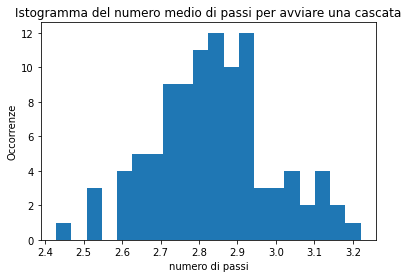

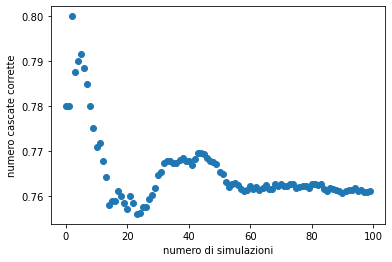

In [77]:
# Creo un istogramma dei dati
counts, bins, _ = plot.hist(counter_senza_None, bins=20)
plot.title("Istogramma del numero medio di passi per avviare una cascata")
plot.xlabel("numero di passi")
plot.ylabel("Occorrenze")
plot.show()

#faccio grafico della percentuale di cascate corrette
plot.scatter(vector_sim, correct_guesses)
plot.xlabel('numero di simulazioni')
plot.ylabel('numero cascate corrette')
plot.show()



# MODELLO CON RIBELLI

### Introduco un partecipante randomico che sceglie in opposizione alla maggioranza. Studio come varia la cascata aumentando la probabilità che un partecipante sia un ribelle ( e quindi il numero dei ribelli ). I ribelli possono interrompere una cascata di informazione, ma solo se sono in numero sufficiente.




In [78]:
priorblue = 0.5
priorred = 0.5
blue = 0
red = 1
#q è la prob che dato lo stato good si abbia un high signal e dato lo stato bad si abbia un low signal (prob che la pallina sia rossa se l'urna è a maggioranza rossa e blu se è a maggioranza blu)
q = 2/3
num_sim = 100

    
#definisce in modo casuale lo stato dell'universo (maggioranza rossa, maggioranza blu)
def universe():
    state = rd.randint(0,1)
    return state

#definisce il numero di partecipanti all'esperimento
def partecipants():
    num = rd.randint(3,100)
    return num

#riempie un vettore con la corretta proporzione di palline a seconda dello stato dell'universo
def vector_world(state):
    alternative = [0,1]
    if state == 1:
        world = [1,1,0]
    else:
        world = [0,0,1]
    return world

#effettua l'estrazione della pallina dall'urna
def extraction(world):
    signal = rd.choice(world)
    return signal

#calcola la probabilità che data una serie di segnali, l'urna sia a maggioranza rossa o blu
def bayes(p, a , b , q):
    denom = (  p * (q**a) * ((1-q)**b) + (1-p) * ((1-q)**a) * (q**b) )
    if denom == 0:
        denom = np.nextafter(0, 1)
    post = ( p * (q**a) * ((1-q)**b) )/ denom
    return post

#effettua la scelta in base alle posterior
def make_decision(postblue, postred, signal):
    if postblue > postred:
        choice = 0
    elif postblue < postred:
        choice = 1 
    else:
        choice = signal
    return choice

#verifica se due giocatori compiono consecutivamente la stessa scelta dando quindi origine ad una cascata\n",
def controller(vector,i):
    if len(vector) == 1:   
        return None
    else:
        if vector[i] == vector[i - 1]:
            return False
        return True


#dinamica per un partecipante
def singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent):
    
    signal = extraction(world)
    if signal == state:
        correct_signal += 1
    if signal == 1:
        a += 1
    else:
        b += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred
   
    choice = make_decision(postblue, postred, signal)
    if signal == choice:
        count_coherent += 1
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

    else:
        if signal == 1: 
            a -= 1
            b += 1
        else:
            a += 1
            b -= 1        
        count_incoherent += 1     
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

#il ribelle sceglie la scelta minoritaria
def rebel(a, b, var, state, correct_signal, count_coherent, count_incoherent, q):
    
    choice = var
    signal = extraction(world)

    if choice == state:
        correct_signal += 1

    if choice == 1:
        a += 1
    else:
        b += 1
        
    if choice == signal:
        count_coherent += 1
    else:
        count_incoherent += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred

    return a, b, choice, signal, count_coherent, count_incoherent,correct_signal, postblue, postred

def prob_rebel():
    return rd.random()

def checkpost(post0,post1):
    if post0 > post1:
        return 0
    elif post0 < post1: 
        return 1
    else:
        return 3
    
def rimuovi_None_e_segna_posizioni(vettore):
    posizioni_None = []
    vettore_senza_None = []
    for i, x in enumerate(vettore):
        if x == None:
            posizioni_None.append(i)
        else:
            vettore_senza_None.append(x)
    return vettore_senza_None, posizioni_None


def rimuovi_elementi(vettore, posizioni_da_rimuovere):
    vettore_senza_elementi = [x for i, x in enumerate(vettore) if i not in posizioni_da_rimuovere]
    return vettore_senza_elementi
        


In [79]:
count_coherent = 0
count_incoherent = 0


#vettore che raccoglie il numero di partecipanti per ogni ciclo su h
vector_participants = []
   
#vettore che raccoglie l'indice di ogni simulazione
vector_sim = []

#vettore che raccoglie ad ogni simulazione la probabilità che un partecipante sia un ribelle
vector_prob_rebel = []

#vettore che raccoglie il rate di cascate corrette facendo la media su numsim simulazioni
correct_cascade_rate = []

#vettore che raccoglie il numero di passi necessari a dare avvio ad una cascata facendo la media su numsim simulazioni
counter = []

#vettore che raccoglie il numero di cascate di informazioni totale facendo la media su numsim simulazioni
counter_cascade = []

#vettore che raccoglie il numero di ribelli necessari a interrompere la cascata facendo la media su numsim simulazioni 
vect_rebel = []

#vettore che raccoglie il numero di ribellioni totali dopo numsim simulazioni
vector_rebellion = []

#vettore che raccoglie le medie di rate di cascate corrette di numsim simulazioni
correct_cascade_rate_total = []

for h in range(0,100):

    #estraggo casualmente il numero di partecipanti dell'esperimento
    numpart = partecipants()
    
    #vettore che raccoglie il numero di partecipanti ad ogni simulazione
    vector_participants.append(numpart)
    
    #prob che un partecipante sia un ribelle
    rebel_prob = prob_rebel()
    
    vector_prob_rebel.append(rebel_prob)
 
    #vettore che raccoglie il numero di ribelli necessari per avviare una ribellione
    vector_rebel_rebellion = []
    
    #conta il numero di simulazioni di tutte le numsim simulazioni
    number_steps = 0
    
    #conta il numero di ribelli
    num_rebel = 0
    
    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di segnali corretti  (per ora non lo uso)
    correct_signal = 0
    
    #conta il numero di ribellioni
    counter_rebellion = 0
         
    #conta il rate di cascate corrette
    mean_correct_cascades = 0
    
    #conta il numero di cascate
    number_cascades = 0
        
    #conta il numero di ribelli che hanno portato ad una ribellione
    num_rebels_for_rebellion = 0
    
    mean_rebels_for_rebellion = 0
    
    mean_steps = 0
    
      
    #conta il numero di ribellioni
    counter_rebellion = 0 
        
    #conta il numero di ribelli che hanno portato ad una ribellione
    num_rebels_for_rebellion = 0
    
    #conta il numero di passi che ci sono voluti per avviare una cascata
    number_steps = 0

    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di cascate
    number_cascades = 0

    
    #faccio num_sim simulazioni
    for j in range(0,num_sim):
        
        
        #conta il numero di ribelli
        num_rebel = 0
        
        #vettore con i numeri da 0 a numpart
        vector_part = []

        #vettore che raccoglie i segnali
        signal_vect = []

        #creo lo stato dell'universo
        state = universe()

        #creo il vettore che contiene la giusta proporzione di palline
        world = vector_world(state)
        
        #inizializzo contatore segnale rosso
        a = 0

        #inizializzo contatore segnale blu
        b = 0

        #vettore delle scelte
        choice = []
        
        #parametro di controllo per la cascata
        control = True
        
        i = 1
        
        diff = 0 
        


        #eseguo la funzione su ogni partecipante all'esperimento
        while i <= numpart:
            
            #se non si è verificata la cascata
            if control == True:
                a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                vector_part.append(i)
                choice.append(single_choice)
                signal_vect.append(signal)
            
                #verifico se due partecipanti consecutivi abbiano fatto la stessa scelta
                if controller(choice,i-1) == False:
                    control = False
                    signal_cascade = single_choice
                    #aggiungo al vettore il numero di passi che ci sono voluti per avviare la cascata
                    number_steps += (i-diff)
                    number_cascades += 1 
                    #verifico se la cascata è corretta
                    if ((choice[i-1] == 0 and state == 0) or (choice[i-1] == 1 and state == 1)):
                        num_correct_cascade += 1
                    max_post = checkpost(postblue,postred)
        
            #se si è verificata la cascata
            else:
                rebel_random = prob_rebel()
                if rebel_random <= rebel_prob:
                    num_rebel += 1
                    a, b, single_choice, signal, count_coherent, count_incoherent, correct_signal, postblue, postred = rebel(a,b,1-signal_cascade,state,correct_signal,count_coherent,count_incoherent,q)
                    vector_part.append(i)
                    choice.append(single_choice)
                    signal_vect.append(signal)
                    max_post_rebel = checkpost(postblue,postred)
                    #se si è verificata la ribellioni
                    if max_post != max_post_rebel:
                        counter_rebellion += 1
                        #numero di ribelli necessari per avviare la ribellione
                        num_rebels_for_rebellion += num_rebel
                        num_rebel = 0
                        control = True
                        diff = i
        
        #qui non dovrei annullare il numero di persone che servono per avviare la cascata
        #per ognuni ciclo fai 100 partecipanti 
        #nel modello ribelli fai andare avanti fino alla fine , vedo solo i partecipanti genuini e non considero l'ultimo ribelle, più aumentano i ribelli, quindi metto i ribelli in generale non solo quando si verifica la cascata
        #nel modello base mi aspetto che ci siano sempre le cascate, invece per i ribelli mi aspetto che si aumenti
                else:
                    a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                    vector_part.append(i)
                    choice.append(single_choice)
                    signal_vect.append(signal)
                
            i += 1
 
  
    #se non si è verificata la cascata aggiungo zero al conteggio della media
    if number_cascades == 0:
        mean_correct_cascades = None
        mean_steps = None
    else:
        mean_correct_cascades = num_correct_cascade/number_cascades
        mean_steps = number_steps/number_cascades
            
    #se non si è verificata la ribellione aggiungo zero al conteggio della media
    if counter_rebellion == 0:
        mean_rebels_for_rebellion = None
    else:
        #sommo i valori medi di ribelli necessari per una ribellione
        mean_rebels_for_rebellion = (num_rebels_for_rebellion/counter_rebellion)

        
   
    #vettore lungo come il numero di cicli su h, che contiene la media di rate di cascate corrette su numsim simulazioni
    correct_cascade_rate.append(mean_correct_cascades) 
    #vettore lungo come il numero di cicli su h, che contiene le medie fatte su numsim simulazioni del numero di partecipanti prima che inizi la cascata
    counter.append(mean_steps)
    #vettore lungo come il numero di cicli su h, che contiene il numero delle cascate in totale nelle numsim simulazioni
    counter_cascade.append(number_cascades)
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribelli necesssari per avviare una ribellione facendo la media su numsim simulazioni 
    vect_rebel.append(mean_rebels_for_rebellion)
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribellioni dopo numsim simulazioni 
    vector_rebellion.append(counter_rebellion)   
    
#elimino i None dai vettori vect_rebel,counter,correct_cascate_rate
correct_cascade_rate_senza_None, posizione_None_correct_cascade_rate = rimuovi_None_e_segna_posizioni(correct_cascade_rate)
counter_senza_None, posizione_None_counter = rimuovi_None_e_segna_posizioni(counter)
vect_rebel_senza_None, posizione_None_vect_rebel = rimuovi_None_e_segna_posizioni(vect_rebel)
vector_prob_rebel_per_cascate = rimuovi_elementi(vector_prob_rebel, posizione_None_counter)
vector_prob_rebel_per_ribellioni = rimuovi_elementi(vector_prob_rebel, posizione_None_vect_rebel)
vector_participants_per_cascate = rimuovi_elementi(vector_participants,posizione_None_counter)
vector_participants_per_ribellioni = rimuovi_elementi(vector_participants,posizione_None_vect_rebel)


print('media passi per avviare una cascata:',np.mean(counter_senza_None))

print('numero medio ribelli per avere una ribellione:',np.mean(vect_rebel_senza_None))


print('numero medio di cascate corrette:',np.mean(correct_cascade_rate_senza_None))


print('numero medio di cascate:',np.mean(counter_cascade))

print('numero medio di ribellioni:',np.mean(vector_rebellion))

media passi per avviare una cascata: 2.2729617950599024
numero medio ribelli per avere una ribellione: 1.9946805500959028
numero medio di cascate corrette: 0.7014603565968034
numero medio di cascate: 714.95
numero medio di ribellioni: 640.68


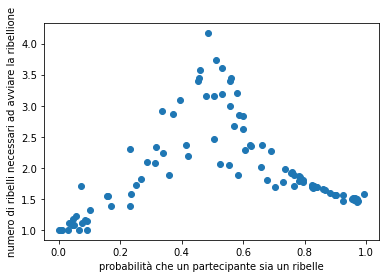

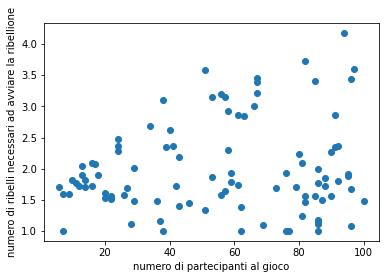

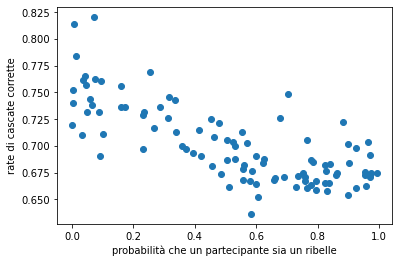

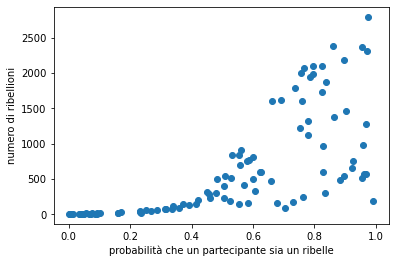

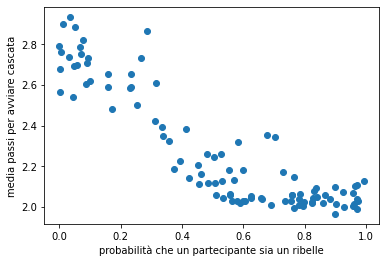

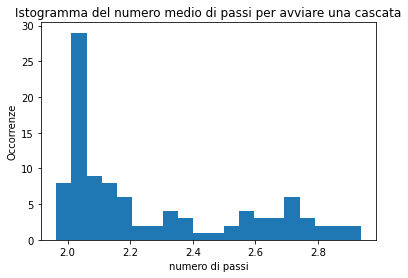

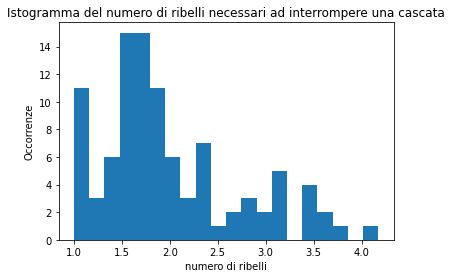

In [80]:
plot.scatter(vector_prob_rebel_per_ribellioni,vect_rebel_senza_None)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('numero di ribelli necessari ad avviare la ribellione')
plot.show()

plot.scatter(vector_participants_per_ribellioni,vect_rebel_senza_None)
plot.xlabel('numero di partecipanti al gioco')
plot.ylabel('numero di ribelli necessari ad avviare la ribellione')
plot.show()

plot.scatter(vector_prob_rebel_per_cascate,correct_cascade_rate_senza_None)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('rate di cascate corrette')
plot.show()


plot.scatter(vector_prob_rebel,vector_rebellion)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('numero di ribellioni')
plot.show()

#mi aspetto che sia costante il numero di passi medio in funzione della probabilità che un partecipante sia un ribelle, invece diminuisce perché?
plot.scatter(vector_prob_rebel_per_cascate, counter_senza_None)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('media passi per avviare cascata')
plot.show()

# Creo un istogramma dei dati
counts, bins, _ = plot.hist(counter_senza_None, bins=20)
plot.title("Istogramma del numero medio di passi per avviare una cascata")
plot.xlabel("numero di passi")
plot.ylabel("Occorrenze")
plot.show()


# Creo un istogramma dei dati
counts, bins, _ = plot.hist(vect_rebel_senza_None, bins=20)
plot.title("Istogramma del numero di ribelli necessari ad interrompere una cascata")
plot.xlabel("numero di ribelli")
plot.ylabel("Occorrenze")
plot.show()


# MODELLO CON PARTECIPANTI CHE SEGUONO IL PROPRIO SEGNALE

In [81]:
priorblue = 0.5
priorred = 0.5
blue = 0
red = 1
#q è la prob che dato lo stato good si abbia un high signal e dato lo stato bad si abbia un low signal (prob che la pallina sia rossa se l'urna è a maggioranza rossa e blu se è a maggioranza blu)
q = 2/3
    
#definisce in modo casuale lo stato dell'universo (maggioranza rossa, maggioranza blu)
def universe():
    state = rd.randint(0,1)
    return state

#definisce il numero di partecipanti all'esperimento
def partecipants():
    num = rd.randint(3,100)
    return num

#riempie un vettore con la corretta proporzione di palline a seconda dello stato dell'universo
def vector_world(state):
    alternative = [0,1]
    if state == 1:
        world = [1,1,0]
    else:
        world = [0,0,1]
    return world

#effettua l'estrazione della pallina dall'urna
def extraction(world):
    signal = rd.choice(world)
    return signal

#calcola la probabilità che data una serie di segnali, l'urna sia a maggioranza rossa o blu
def bayes(p, a , b , q):
    denom = ( p * (q**a) * ((1-q)**b) + (1-p) * ((1-q)**a) * (q**b) )
    if denom == 0:
        denom = np.nextafter(0, 1)
    post = ( p * (q**a) * ((1-q)**b) )/ denom
    return post

#effettua la scelta in base alle posterior
def make_decision(postblue, postred, signal):
    if postblue > postred:
        choice = 0
    elif postblue < postred:
        choice = 1 
    else:
        choice = signal
    return choice

#verifica se due giocatori compiono consecutivamente la stessa scelta dando quindi origine ad una cascata\n",
def controller(vector,i):
    if len(vector) == 1:   
        return None
    else:
        if vector[i] == vector[i - 1]:
            return False
        return True


#dinamica per un partecipante
def singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent):
    
    signal = extraction(world)
    if signal == state:
        correct_signal += 1
    if signal == 1:
        a += 1
    else:
        b += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred
   
    choice = make_decision(postblue, postred, signal)
    if signal == choice:
        count_coherent += 1
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

    else:
        if signal == 1: 
            a -= 1
            b += 1
        else:
            a += 1
            b -= 1        
        count_incoherent += 1     
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

#il ribelle sceglie secondo il proprio segnale
def rebel(a, b, state, correct_signal, count_coherent, count_incoherent, q):
    
    choice = extraction(world)

    if choice == state:
        correct_signal += 1

    if choice == 1:
        a += 1
    else:
        b += 1
        
    count_coherent += 1
   
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred

    return a, b, choice, count_coherent, count_incoherent,correct_signal, postblue, postred

def prob_rebel():
    return rd.random()

def checkpost(post0,post1):
    if post0 > post1:
        return 0
    elif post0 < post1: 
        return 1
    else:
        return 3

def rimuovi_None_e_segna_posizioni(vettore):
    posizioni_None = []
    vettore_senza_None = []
    for i, x in enumerate(vettore):
        if x == None:
            posizioni_None.append(i)
        else:
            vettore_senza_None.append(x)
    return vettore_senza_None, posizioni_None


def rimuovi_elementi(vettore, posizioni_da_rimuovere):
    vettore_senza_elementi = [x for i, x in enumerate(vettore) if i not in posizioni_da_rimuovere]
    return vettore_senza_elementi
        

In [82]:
#vettore che raccoglie il numero di partecipanti per ogni ciclo su h
vector_participants = []
    
#vettore che raccoglie l'indice di ogni simulazione
vector_sim = []

#vettore che raccoglie ad ogni simulazione la probabilità che un partecipante sia un ribelle
vector_prob_rebel = []

#vettore che raccoglie il rate di cascate corrette facendo la media su numsim simulazioni
correct_cascade_rate = []

#vettore che raccoglie il numero di passi necessari a dare avvio ad una cascata facendo la media su numsim simulazioni
counter = []

#vettore che raccoglie il numero di cascate di informazioni totale facendo la media su numsim simulazioni
counter_cascade = []

#vettore che raccoglie il numero di ribelli necessari a interrompere la cascata facendo la media su numsim simulazioni 
vect_rebel = []

#vettore che raccoglie il numero di ribellioni totali dopo numsim simulazioni
vector_rebellion = []

#vettore che raccoglie le medie di rate di cascate corrette di numsim simulazioni
correct_cascade_rate_total = []
    
for h in range(0,100):

    #estraggo casualmente il numero di partecipanti dell'esperimento
    numpart = partecipants()
    
    #vettore che raccoglie il numero di partecipanti ad ogni simulazione
    vector_participants.append(numpart)
    
    #prob che un partecipante sia un ribelle
    rebel_prob = prob_rebel()
    
    vector_prob_rebel.append(rebel_prob)
    
    #vettore che raccoglie il numero di ribelli necessari per avviare una ribellione
    vector_rebel_rebellion = []
    
    #conta il numero di simulazioni di tutte le numsim simulazioni
    number_steps = 0
    
    #conta il numero di ribelli
    num_rebel = 0
    
    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di segnali corretti  (per ora non lo uso)
    correct_signal = 0
    
    #conta il numero di ribellioni
    counter_rebellion = 0
         
    #conta il rate di cascate corrette
    mean_correct_cascades = 0
    
    #conta il numero di cascate
    number_cascades = 0
        
    #conta il numero di ribelli che hanno portato ad una ribellione
    num_rebels_for_rebellion = 0
    
    mean_rebels_for_rebellion = 0
    
    mean_steps = 0
      
    #conta il numero di ribellioni
    counter_rebellion = 0 
        
    #conta il numero di ribelli che hanno portato ad una ribellione
    num_rebels_for_rebellion = 0
    
    #conta il numero di passi che ci sono voluti per avviare una cascata
    number_steps = 0

    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di cascate
    number_cascades = 0

    #faccio num_sim simulazioni
    for j in range(0,num_sim):
        
        #conta il numero di ribelli
        num_rebel = 0
        
        #vettore con i numeri da 0 a numpart
        vector_part = []

        #vettore che raccoglie i segnali
        signal_vect = []

        #creo lo stato dell'universo
        state = universe()

        #creo il vettore che contiene la giusta proporzione di palline
        world = vector_world(state)
        
        #inizializzo contatore segnale rosso
        a = 0

        #inizializzo contatore segnale blu
        b = 0

        #vettore delle scelte
        choice = []

        #parametro di controllo per la cascata
        control = True
        
        i = 1
        
        diff = 0 
       
        
        
        #eseguo la funzione su ogni partecipante all'esperimento
        while i <= numpart:
            
            #se non si è verificata la cascata
            if control == True:
                a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                vector_part.append(i)
                choice.append(single_choice)
                signal_vect.append(signal)
                
            
                #verifico se due partecipanti consecutivi abbiano fatto la stessa scelta
                if controller(choice,i-1) == False:
                    control = False
                    signal_cascade = single_choice
                    #aggiungo al vettore il numero di passi che ci sono voluti per avviare la cascata
                    number_steps += (i-diff)
                    number_cascades += 1 
                    #verifico se la cascata è corretta
                    if ((choice[i-1] == 0 and state == 0) or (choice[i-1] == 1 and state == 1)):
                        num_correct_cascade += 1
                    max_post = checkpost(postblue,postred)
        
            #se si è verificata la cascata
            else:
                
                rebel_random = prob_rebel()
                if rebel_random <= rebel_prob:
                    num_rebel += 1
                    a, b, signal, count_coherent, count_incoherent, correct_signal, postblue, postred = rebel(a,b,state,correct_signal,count_coherent,count_incoherent,q)
                    vector_part.append(i)
                    choice.append(signal)
                    signal_vect.append(signal)
                    max_post_rebel = checkpost(postblue,postred)
                    if max_post != max_post_rebel:
                        counter_rebellion += 1
                        #numero di ribelli necessari per avviare la ribellione
                        num_rebels_for_rebellion += num_rebel
                        num_rebel = 0
                        control = True
                        diff = i
        
                    
                else:
                    a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                    vector_part.append(i)
                    choice.append(single_choice)
                    signal_vect.append(signal)
                    
            i += 1
    
    
    #se non si è verificata la cascata aggiungo zero al conteggio della media
    if number_cascades == 0:
        mean_correct_cascades = None
        mean_steps = None
    else:
        mean_correct_cascades = num_correct_cascade/number_cascades
        mean_steps = number_steps/number_cascades
            
    #se non si è verificata la ribellione aggiungo zero al conteggio della media
    if counter_rebellion == 0:
        mean_rebels_for_rebellion = None
    else:
        #sommo i valori medi di ribelli necessari per una ribellione
        mean_rebels_for_rebellion = (num_rebels_for_rebellion/counter_rebellion)

    #vettore lungo come il numero di cicli su h, che contiene la media di rate di cascate corrette su numsim simulazioni
    correct_cascade_rate.append(mean_correct_cascades)    
    #vettore lungo come il numero di cicli su h, che contiene le medie fatte su numsim simulazioni del numero di partecipanti prima che inizi la cascata
    counter.append(mean_steps)
    #vettore lungo come il numero di cicli su h, che contiene il numero delle cascate in totale nelle numsim simulazioni
    counter_cascade.append(number_cascades)
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribelli necesssari per avviare una ribellione facendo la media su numsim simulazioni 
    vect_rebel.append(mean_rebels_for_rebellion)
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribellioni dopo numsim simulazioni 
    vector_rebellion.append(counter_rebellion)   
    
#elimino i None dai vettori vect_rebel,counter,correct_cascate_rate
correct_cascade_rate_senza_None, posizione_None_correct_cascade_rate = rimuovi_None_e_segna_posizioni(correct_cascade_rate)
counter_senza_None, posizione_None_counter = rimuovi_None_e_segna_posizioni(counter)
vect_rebel_senza_None, posizione_None_vect_rebel = rimuovi_None_e_segna_posizioni(vect_rebel)
vector_prob_rebel_per_cascate = rimuovi_elementi(vector_prob_rebel, posizione_None_counter)
vector_prob_rebel_per_ribellioni = rimuovi_elementi(vector_prob_rebel, posizione_None_vect_rebel)
vector_participants_per_cascate = rimuovi_elementi(vector_participants,posizione_None_counter)
vector_participants_per_ribellioni = rimuovi_elementi(vector_participants,posizione_None_vect_rebel)

print('media passi per avviare una cascata:',np.mean(counter_senza_None))

print('numero medio ribelli per avere una ribellione:',np.mean(vect_rebel_senza_None))


print('numero medio di cascate corrette:',np.mean(correct_cascade_rate_senza_None))


print('numero medio di cascate:',np.mean(counter_cascade))


print('numero medio di ribellioni:',np.mean(vector_rebellion))

media passi per avviare una cascata: 2.6134981774502135
numero medio ribelli per avere una ribellione: 2.235122084891736
numero medio di cascate corrette: 0.7613972777165425
numero medio di cascate: 133.05
numero medio di ribellioni: 33.76


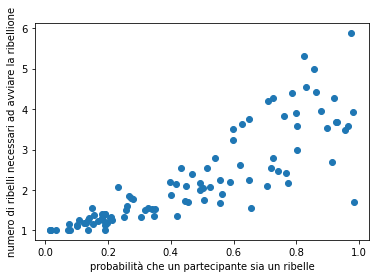

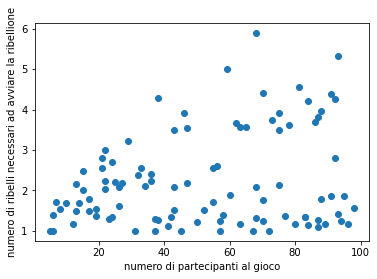

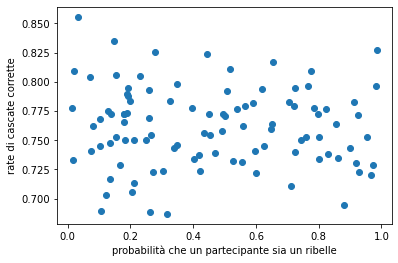

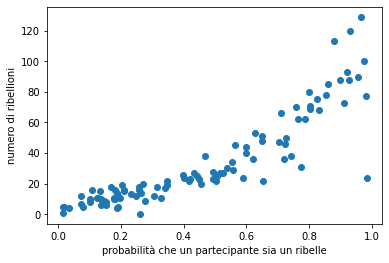

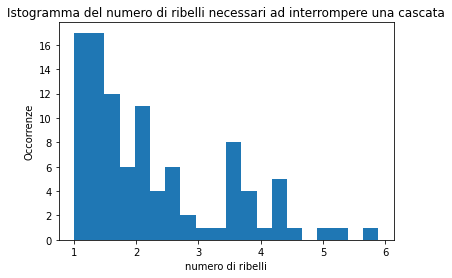

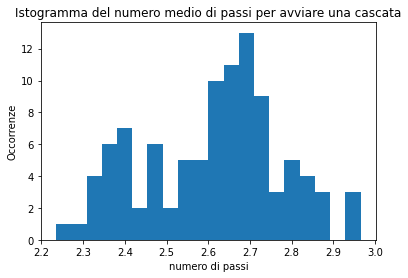

In [83]:
from scipy.stats import poisson
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt




plot.scatter(vector_prob_rebel_per_ribellioni,vect_rebel_senza_None)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('numero di ribelli necessari ad avviare la ribellione')
plot.show()

plot.scatter(vector_participants_per_ribellioni,vect_rebel_senza_None)
plot.xlabel('numero di partecipanti al gioco')
plot.ylabel('numero di ribelli necessari ad avviare la ribellione')
plot.show()

plot.scatter(vector_prob_rebel_per_cascate,correct_cascade_rate_senza_None)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('rate di cascate corrette')
plot.show()


plot.scatter(vector_prob_rebel,vector_rebellion)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('numero di ribellioni')
plot.show()

# Creo un istogramma dei dati
counts, bins, _ = plot.hist(vect_rebel_senza_None, bins=20)
plot.title("Istogramma del numero di ribelli necessari ad interrompere una cascata")
plot.xlabel("numero di ribelli")
plot.ylabel("Occorrenze")
plot.show()



# Creo un istogramma dei dati
counts, bins, _ = plot.hist(counter_senza_None, bins=20)
plot.title("Istogramma del numero medio di passi per avviare una cascata")
plot.xlabel("numero di passi")
plot.ylabel("Occorrenze")
plot.show()